# https://doorbw.tistory.com/169 참고함

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
!move "C:\Users\jju53\OneDrive\바탕 화면\train_titanic.csv" .
!move "C:\Users\jju53\OneDrive\바탕 화면\test_titanic.csv" .

        1개 파일을 이동했습니다.


# 데이터 불러오기

* Survivied는 생존 여부(0은 사망, 1은 생존; train 데이터에서만 제공),
* Pclass는 사회경제적 지위(1에 가까울 수록 높음),
* SipSp는 배우자나 형제 자매 명 수의 총 합,
* Parch는 부모 자식 명 수의 총 합을 나타낸다.
* Embarked : 승선한 항구명(C : Cherbourg, Q : Queenstown, S : Southampton)
**Cherbourg : 셰르부르, 프랑스 서북부의 도시
**Queenstown : 퀸스타운 (뉴질랜드)
**Southampton : 영국 잉글랜드 남동부에 있는 항구도시


In [144]:
train=pd.read_csv('./train_titanic.csv')
train_df=pd.DataFrame(train).copy()
train_id=train['PassengerId'].tolist()



test=pd.read_csv('./test_titanic.csv')
test_df=pd.DataFrame(test).copy()
test_id=test_df['PassengerId'].tolist()


all_df=train_df.append(test_df)

all_df.reset_index(inplace=True)
all_df.tail(5)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [145]:
all_df.isnull().sum()

index             0
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [146]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
all_df['Sex'] = encoder.fit_transform(all_df['Sex'])
print(encoder.classes_) #[female, male]
all_df['Sex'].value_counts()

['female' 'male']


1    843
0    466
Name: Sex, dtype: int64

# 데이터 수정
* 이름당 사망자 수에 따라 순위로 매긴 수치형 변수 'surname'으로 수정

In [147]:
all_df['surname']=all_df.Name.str.split(',').str[1].str.split('.').str[0].str.replace(' ','')
all_df['surname'].value_counts()


Mr             757
Miss           260
Mrs            197
Master          61
Dr               8
Rev              8
Col              4
Major            2
Ms               2
Mlle             2
theCountess      1
Lady             1
Dona             1
Don              1
Mme              1
Sir              1
Capt             1
Jonkheer         1
Name: surname, dtype: int64

In [148]:
all_df[all_df['surname'] == 'Rev'] # 신부(남자)
all_df[all_df['surname'] == 'Capt']# 선장


# 영어 아닌 단어로 Miss를 뜻하고 있어 수정
all_df[all_df['surname'] == 'Mlle'] # Mlle=Miss
all_df[all_df['surname'] == 'Lady'] #Lady = Miss
all_df[all_df['surname'] == 'Mme']
#Mme=영부인=Mrs 그런데 실제 이 사람은 24세에 sipsp합이 0이라 miss로 바꿈
miss = all_df[all_df['surname'].str.contains('Mlle|Lady|Mme')].index.tolist()
for i in miss:
    all_df['surname'][i] = 'Miss'


# Mrs로 수정
all_df[all_df['surname'] == 'Dona']# 귀부인, Madam, lady
mrs = all_df[all_df['surname'].str.contains('Dona')].index.tolist()
for i in mrs:
    all_df['surname'][i] = 'Mrs'
    
# 귀족
all_df[all_df['surname'] == 'theCountess'] # 백작부인
all_df[all_df['surname'] == 'Don']#백작
all_df[all_df['surname'] == 'Sir'] # 영국에서 나이트 or 준남작
all_df[all_df['surname'] == 'Jonkheer'] # 네덜란드 작위없는 귀족
noblesse = all_df[all_df['surname'].str.contains('theCountess|Don|Sir|Jonkheer')].index.tolist()
for i in noblesse:
    all_df['surname'][i] = 'Noblesse'

# 군인
all_df[all_df['surname'] == 'Col'] # 대령(군인, 남자)
all_df[all_df['surname'] == 'Major'] # 소령
soldier = all_df[all_df['surname'].str.contains('Col|Major')].index.tolist()
for i in soldier:
    all_df['surname'][i] = 'Soldier'

    
    
    
all_df['surname'].value_counts()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
149,149,150,0.0,2,"Byles, Rev. Thomas Roussel Davids",1,42.0,0,0,244310,13.000,NaN,S,Rev
150,150,151,0.0,2,"Bateman, Rev. Robert James",1,51.0,0,0,S.O.P. 1166,12.525,NaN,S,Rev
249,249,250,0.0,2,"Carter, Rev. Ernest Courtenay",1,54.0,1,0,244252,26.000,NaN,S,Rev
626,626,627,0.0,2,"Kirkland, Rev. Charles Leonard",1,57.0,0,0,219533,12.350,NaN,Q,Rev
848,848,849,0.0,2,"Harper, Rev. John",1,28.0,0,1,248727,33.000,NaN,S,Rev
886,886,887,0.0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.000,NaN,S,Rev
1040,149,1041,NaN,2,"Lahtinen, Rev. William",1,30.0,1,1,250651,26.000,NaN,S,Rev
1055,164,1056,NaN,2,"Peruschitz, Rev. Joseph Maria",1,41.0,0,0,237393,13.000,NaN,S,Rev


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
745,745,746,0.0,1,"Crosby, Capt. Edward Gifford",1,70.0,1,1,WE/P 5735,71.0,B22,S,Capt


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
641,641,642,1.0,1,"Sagesser, Mlle. Emma",0,24.0,0,0,PC 17477,69.3000,B35,C,Mlle
710,710,711,1.0,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",0,24.0,0,0,PC 17482,49.5042,C90,C,Mlle


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
556,556,557,1.0,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",0,48.0,1,0,11755,39.6,A16,C,Lady


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
369,369,370,1.0,1,"Aubart, Mme. Leontine Pauline",0,24.0,0,0,PC 17477,69.3,B35,C,Mme


C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
1305,414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9,C105,C,Dona


C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
759,759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",0,33.0,0,0,110152,86.5,B77,S,theCountess


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
30,30,31,0.0,1,"Uruchurtu, Don. Manuel E",1,40.0,0,0,PC 17601,27.7208,NaN,C,Don


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
599,599,600,1.0,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",1,49.0,1,0,PC 17485,56.9292,A20,C,Sir


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
822,822,823,0.0,1,"Reuchlin, Jonkheer. John George",1,38.0,0,0,19972,0.0,NaN,S,Jonkheer


C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
647,647,648,1.0,1,"Simonius-Blumer, Col. Oberst Alfons",1,56.0,0,0,13213,35.500,A26,C,Col
694,694,695,0.0,1,"Weir, Col. John",1,60.0,0,0,113800,26.550,NaN,S,Col
1022,131,1023,NaN,1,"Gracie, Col. Archibald IV",1,53.0,0,0,113780,28.500,C51,C,Col
1093,202,1094,NaN,1,"Astor, Col. John Jacob",1,47.0,1,0,PC 17757,227.525,C62 C64,C,Col


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
449,449,450,1.0,1,"Peuchen, Major. Arthur Godfrey",1,52.0,0,0,113786,30.50,C104,S,Major
536,536,537,0.0,1,"Butt, Major. Archibald Willingham",1,45.0,0,0,113050,26.55,B38,S,Major


C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mr          757
Miss        264
Mrs         198
Master       61
Dr            8
Rev           8
Soldier       6
Noblesse      4
Ms            2
Capt          1
Name: surname, dtype: int64

In [149]:
all_df.Survived[all_df['surname']=='Ms'].value_counts()

1.0    1
Name: Survived, dtype: int64

In [150]:
# 사망률이 높은 범주 확인
c=pd.DataFrame()
for title in all_df['surname'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['surname']==title].value_counts()/sum(all_df.Survived[all_df['surname']==title].value_counts()),
                      columns=['Survived', 'surname_replace'])
    a=a[a.index==0]
    a['surname_replace']=title
    c=c.append(a)
    
c=c.drop_duplicates(['surname_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c


,Survived,surname_replace
0,1.000000,Rev
1,1.000000,Capt
2,0.843327,Mr
3,0.571429,Dr
4,0.500000,Noblesse
5,0.500000,Soldier
6,0.425000,Master
7,0.295699,Miss
8,0.208000,Mrs


In [151]:
# 각 이름별로 많이 죽은 성 -> 적게 죽은 성 순서대로 값을 매기기
# 이에 따라 name 변수 수정


name_replace ={
    'Rev':0,
    'Capt':0,
    'Ms':7,
    'Noblesse':3,
    'Soldier':3,
    'Dr':2,
    'Master':4,
    'Mrs':6,
    'Miss':5,
    'Mr':1  
}


In [152]:
all_df['surname'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Noblesse', 'Rev', 'Dr', 'Ms',
       'Soldier', 'Capt'], dtype=object)

In [153]:
all_df['surname']=all_df['surname'].apply(lambda x: name_replace.get(x))
all_df['surname']

0       1
1       6
2       5
3       6
4       1
       ..
1304    1
1305    6
1306    1
1307    1
1308    4
Name: surname, Length: 1309, dtype: int64

# Missing data & 사망률에 따라 범위 지정

## Age를 surname에 따라 평균으로 내서 대체해줌

In [154]:
all_df.isnull().sum()
all_df.info()

index             0
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
surname           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1309 non-null   int64  
 1   PassengerId  1309 non-null   int64  
 2   Survived     891 non-null    float64
 3   Pclass       1309 non-null   int64  
 4   Name         1309 non-null   object 
 5   Sex          1309 non-null   int32  
 6   Age          1046 non-null   float64
 7   SibSp        1309 non-null   int64  
 8   Parch        1309 non-null   int64  
 9   Ticket       1309 non-null   object 
 10  Fare         1308 non-null   float64
 11  Cabin        295 non-null    object 
 12  Embarked     1307 non-null   object 
 13  surname      1309 non-null   int64  
dtypes: float64(3), int32(1), int64(6), object(4)
memory usage: 138.2+ KB


In [155]:
age_miss= pd.DataFrame(all_df.groupby(['surname','Sex'])['Age'].mean())

age_miss.columns=['Age_mean']
age_miss
missing = all_df[all_df['Age'].isnull()].index.tolist()



for i in missing:
    for j in list(range(len(age_miss))):
        if (all_df['surname'][i],all_df['Sex'][i]) == age_miss.index.tolist()[j]:
            all_df['Age'][i] = age_miss['Age_mean'].tolist()[j] 
            break

all_df.isnull().sum()

Age_mean
surname Sex           
0       1    44.444444
1       1    32.252151
2       0    49.000000
        1    42.666667
3       0    33.000000
        1    48.888889
4       1     5.482642
5       0    21.927991
6       0    37.005848
7       0    28.000000

C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


index             0
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
surname           0
dtype: int64

In [156]:
all_df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
0,0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,6
2,2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,6
4,4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,1


In [157]:
all_df_list=[all_df]

for dataset in all_df_list:
    dataset.loc[dataset['Age']<=10, 'Age'] = 0,
    dataset.loc[(dataset['Age']>10) &(dataset['Age']<=15), 'Age'] = 1,
    dataset.loc[(dataset['Age']>15) &(dataset['Age']<=20), 'Age'] = 2,
    dataset.loc[(dataset['Age']>20) &(dataset['Age']<=25), 'Age'] = 3,
    dataset.loc[(dataset['Age']>25) &(dataset['Age']<=30), 'Age'] = 4,
    dataset.loc[(dataset['Age']>30) &(dataset['Age']<=35), 'Age'] = 5,
    dataset.loc[(dataset['Age']>35) &(dataset['Age']<=40), 'Age'] = 6,
    dataset.loc[(dataset['Age']>40) &(dataset['Age']<=45), 'Age'] = 7,
    dataset.loc[(dataset['Age']>45) &(dataset['Age']<=50), 'Age'] = 8,
    dataset.loc[(dataset['Age']>50) &(dataset['Age']<=55), 'Age'] = 9,
    dataset.loc[(dataset['Age']>55) &(dataset['Age']<=60), 'Age'] = 10,
    dataset.loc[dataset['Age']>60, 'Age'] = 11
    
all_df['Age'].describe()

count    1309.000000
mean        4.448434
std         2.492768
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        11.000000
Name: Age, dtype: float64

In [158]:
# 사망률이 높은 범주 확인

c=pd.DataFrame()
for age in all_df['Age'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['Age']==age].value_counts()/sum(all_df.Survived[all_df['Age']==age].value_counts()),
                      columns=['Survived', 'age_replace'])
    a=a[a.index==0]
    a['age_replace']=age
    c=c.append(a)
c=c.drop_duplicates(['age_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c

    

    


,Survived,age_replace
0,0.772727,11.0
1,0.734300,5.0
2,0.656250,2.0
3,0.645833,7.0
4,0.611111,4.0
5,0.611111,10.0
6,0.594937,3.0
7,0.589744,8.0
8,0.583333,9.0
9,0.500000,6.0


In [159]:
age_point_replace={
    0:10,
    1:9,
    2:2,
    3:5,
    4:4,
    5:1,
    6:8,
    7:3,
    8:6,
    9:7,
    10:4,
    11:0,
}

In [160]:
for dataset in all_df_list:
    dataset['age_point']=dataset['Age'].apply(lambda x: age_point_replace.get(x))

all_df['age_point']
all_df['Age']

0        5
1        8
2        4
3        1
4        1
        ..
1304     1
1305     8
1306     8
1307     1
1308    10
Name: age_point, Length: 1309, dtype: int64

0       3.0
1       6.0
2       4.0
3       5.0
4       5.0
       ... 
1304    5.0
1305    6.0
1306    6.0
1307    5.0
1308    0.0
Name: Age, Length: 1309, dtype: float64

## sibSP+Parch+1 = Familysize

* Familysize>4일 경우 아버지일 확률이 높고, 사회적으로 아버지는 자신의 가족을 먼저 살리려고 했을 것이라고 가정 하에 변수 생성

In [161]:
for dataset in all_df_list:
    dataset['Familysize'] = dataset['SibSp']+dataset['Parch']+1
    
all_df['Familysize'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Familysize, dtype: int64

In [162]:
maybe_dad_mask = (all_df['Familysize'] > 4) & (all_df['Sex']==1)
maybe_dad_mask.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [163]:
all_df['maybe_dad']=1

In [164]:
all_df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,age_point,Familysize,maybe_dad
0,0,1,0.0,3,"Braund, Mr. Owen Harris",1,3.0,1,0,A/5 21171,7.2500,NaN,S,1,5,2,1
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,6.0,1,0,PC 17599,71.2833,C85,C,6,8,2,1
2,2,3,1.0,3,"Heikkinen, Miss. Laina",0,4.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5,4,1,1
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,5.0,1,0,113803,53.1000,C123,S,6,1,2,1
4,4,5,0.0,3,"Allen, Mr. William Henry",1,5.0,0,0,373450,8.0500,NaN,S,1,1,1,1


In [165]:
all_df.loc[maybe_dad_mask, 'maybe_dad'] = 0

In [166]:
all_df[all_df['maybe_dad']==0].head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,age_point,Familysize,maybe_dad
7,7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,0.0,3,1,349909,21.0750,NaN,S,4,10,5,0
13,13,14,0.0,3,"Andersson, Mr. Anders Johan",1,6.0,1,5,347082,31.2750,NaN,S,1,8,7,0
16,16,17,0.0,3,"Rice, Master. Eugene",1,0.0,4,1,382652,29.1250,NaN,Q,4,10,6,0
27,27,28,0.0,1,"Fortune, Mr. Charles Alexander",1,2.0,3,2,19950,263.0000,C23 C25 C27,S,1,2,6,0
50,50,51,0.0,3,"Panula, Master. Juha Niilo",1,0.0,4,1,3101295,39.6875,NaN,S,4,10,6,0


In [167]:

c=pd.DataFrame()
for dad in all_df['maybe_dad'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['maybe_dad']==dad].value_counts()/sum(all_df.Survived[all_df['maybe_dad']==dad].value_counts()),
                      columns=['Survived', 'maybe_dad_replace'])
    a=a[a.index==0]
    a['maybe_dad_replace']=dad
    c=c.append(a)
c=c.drop_duplicates(['maybe_dad_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c

    




,Survived,maybe_dad_replace
0,0.965517,0
1,0.604408,1


## Familysize

In [168]:
all_df['Familysize'].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11], dtype=int64)

In [169]:
# 사망률이 높은 범주 확인
c=pd.DataFrame()
for size in all_df['Familysize'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['Familysize']==size].value_counts()/sum(all_df.Survived[all_df['Familysize']==size].value_counts()),
                      columns=['Survived', 'Familysize_replace'])
    a=a[a.index==0]
    a['Familysize_replace']=size
    c=c.append(a)
c=c.drop_duplicates(['Familysize_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c

    


,Survived,Familysize_replace
0,1.000000,8
1,1.000000,11
2,0.863636,6
3,0.800000,5
4,0.696462,1
5,0.666667,7
6,0.447205,2
7,0.421569,3
8,0.275862,4


In [170]:
familysize_replace={
    1:3,
    2:5,
    3:6,
    4:7,
    5:2,
    6:1,
    7:4,
    8:0,
    11:0
}

all_df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,age_point,Familysize,maybe_dad
0,0,1,0.0,3,"Braund, Mr. Owen Harris",1,3.0,1,0,A/5 21171,7.2500,NaN,S,1,5,2,1
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,6.0,1,0,PC 17599,71.2833,C85,C,6,8,2,1
2,2,3,1.0,3,"Heikkinen, Miss. Laina",0,4.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5,4,1,1
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,5.0,1,0,113803,53.1000,C123,S,6,1,2,1
4,4,5,0.0,3,"Allen, Mr. William Henry",1,5.0,0,0,373450,8.0500,NaN,S,1,1,1,1


In [171]:
all_df['fs_point']=all_df['Familysize'].apply(lambda x: familysize_replace.get(x))
all_df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,age_point,Familysize,maybe_dad,fs_point
0,0,1,0.0,3,"Braund, Mr. Owen Harris",1,3.0,1,0,A/5 21171,7.2500,NaN,S,1,5,2,1,5
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,6.0,1,0,PC 17599,71.2833,C85,C,6,8,2,1,5
2,2,3,1.0,3,"Heikkinen, Miss. Laina",0,4.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5,4,1,1,3
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,5.0,1,0,113803,53.1000,C123,S,6,1,2,1,5
4,4,5,0.0,3,"Allen, Mr. William Henry",1,5.0,0,0,373450,8.0500,NaN,S,1,1,1,1,3


## Pclass별로 생존비율 확인 후 새로운 값 매기기

In [172]:
all_df['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [173]:
# 사망률이 높은 범주 확인

c=pd.DataFrame()
for x in all_df['Pclass'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['Pclass']==x].value_counts()/sum(all_df.Survived[all_df['Pclass']==x].value_counts()),
                      columns=['Survived', 'Pclass_replace'])
    a=a[a.index==0]
    a['Pclass_replace']=x
    c=c.append(a)
c=c.drop_duplicates(['Pclass_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c 


,Survived,Pclass_replace
0,0.757637,3
1,0.527174,2
2,0.370370,1


In [174]:
for dataset in all_df_list:
    dataset.loc[dataset['Pclass']==3,'Pclass_point']=0
    dataset.loc[dataset['Pclass']==2, 'Pclass_point']=1
    dataset.loc[dataset['Pclass']==1, 'Pclass_point']=2

## Embarked missing
 * 큰 값이 있어서 median사용
 * 숫자로 변형
 * Embarked 당 사망률 계산

In [175]:
all_df['Embarked'].value_counts()

all_df[all_df['Embarked'].isnull()].index.tolist()
all_df['Embarked'][61]='S'
all_df['Embarked'][829]='S'

all_df.isnull().sum()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

[61, 829]

C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


index              0
PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin           1014
Embarked           0
surname            0
age_point          0
Familysize         0
maybe_dad          0
fs_point           0
Pclass_point       0
dtype: int64

In [176]:
embarked_mapping={'S':0, 'C':1, 'Q':2}


embarked_mapping



all_df['Embarked']=all_df['Embarked'].apply(lambda x: embarked_mapping.get(x))
all_df['Embarked']

all_df

{'S': 0, 'C': 1, 'Q': 2}

0       0
1       1
2       0
3       0
4       0
       ..
1304    0
1305    1
1306    0
1307    0
1308    1
Name: Embarked, Length: 1309, dtype: int64

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,age_point,Familysize,maybe_dad,fs_point,Pclass_point
0,0,1,0.0,3,"Braund, Mr. Owen Harris",1,3.0,1,0,A/5 21171,7.2500,NaN,0,1,5,2,1,5,0.0
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,6.0,1,0,PC 17599,71.2833,C85,1,6,8,2,1,5,2.0
2,2,3,1.0,3,"Heikkinen, Miss. Laina",0,4.0,0,0,STON/O2. 3101282,7.9250,NaN,0,5,4,1,1,3,0.0
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,5.0,1,0,113803,53.1000,C123,0,6,1,2,1,5,2.0
4,4,5,0.0,3,"Allen, Mr. William Henry",1,5.0,0,0,373450,8.0500,NaN,0,1,1,1,1,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,413,1305,NaN,3,"Spector, Mr. Woolf",1,5.0,0,0,A.5. 3236,8.0500,NaN,0,1,1,1,1,3,0.0
1305,414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,6.0,0,0,PC 17758,108.9000,C105,1,6,8,1,1,3,2.0
1306,415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,6.0,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,1,8,1,1,3,0.0
1307,416,1308,NaN,3,"Ware, Mr. Frederick",1,5.0,0,0,359309,8.0500,NaN,0,1,1,1,1,3,0.0


In [177]:
all_df['Embarked'].unique()



array([0, 1, 2], dtype=int64)

In [178]:
# 사망률이 높은 범주 확인
c=pd.DataFrame()
for x in all_df['Embarked'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['Embarked']==x].value_counts()/sum(all_df.Survived[all_df['Embarked']==x].value_counts()),
                      columns=['Survived', 'Embarked_replace'])
    a=a[a.index==0]
    a['Embarked_replace']=x
    c=c.append(a)
c=c.drop_duplicates(['Embarked_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c

,Survived,Embarked_replace
0,0.660991,0
1,0.610390,2
2,0.446429,1


In [179]:
for dateset in all_df_list:
    dataset.loc[dataset['Embarked']==0,'Em_point']=0
    dataset.loc[dataset['Embarked']==2,'Em_point']=1
    dataset.loc[dataset['Embarked']==1,'Em_point']=2

## Fare missing & Cabin 
 * Fare : 큰 값이 있어서 median사용

In [180]:
all_df['Fare'].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [181]:
#큰 값이 쏠려있어서 mean이 아닌 median으로 줌

all_df[all_df['Fare'].isnull()].index.tolist()
all_df['Fare'][1043]=14.4542
all_df.isnull().sum()

[1043]

C:\Users\jju53\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


index              0
PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin           1014
Embarked           0
surname            0
age_point          0
Familysize         0
maybe_dad          0
fs_point           0
Pclass_point       0
Em_point           0
dtype: int64

In [182]:
# 임의로 fillna에 U 넣어줌
all_df['Cabin'].fillna('U', inplace=True)
all_df['Cabin']=all_df['Cabin'].apply(lambda x : x[0])
all_df['Cabin'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [184]:
all_df['Fare'].describe()

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [185]:
for dataset in all_df_list:
    dataset.loc[dataset['Fare']<=30, 'Fare'] = 0,
    dataset.loc[(dataset['Fare']>30)&(dataset['Fare']<=80), 'Fare'] = 1,
    dataset.loc[(dataset['Fare']>80)&(dataset['Fare']<=100), 'Fare'] = 2,
    dataset.loc[dataset['Fare']>100, 'Fare'] = 3
    


In [186]:
all_df['Fare'].unique()

array([0., 1., 3., 2.])

In [204]:
c=pd.DataFrame()
for x in all_df['Fare'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['Fare']==x].value_counts()/sum(all_df.Survived[all_df['Fare']==x].value_counts()),
                      columns=['Survived', 'Fare_replace'])
    a=a[a.index==0]
    a['Fare_replace']=x
    c=c.append(a)
c=c.drop_duplicates(['Fare_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c 


,Survived,Fare_replace
0,0.686454,0.0
1,0.506250,1.0
2,0.264151,3.0
3,0.142857,2.0


In [206]:
fare_replace={
    0:0,
    1:2,
    2:3,
    3:2
}

all_df['Fare_point']=all_df['Fare'].apply(lambda x: fare_replace.get(x))

Text(0.5, 1.0, 'Cabin : U')

Text(0.5, 1.0, 'Cabin : C')

Text(0.5, 1.0, 'Cabin : E')

Text(0.5, 1.0, 'Cabin : G')

Text(0.5, 1.0, 'Cabin : D')

Text(0.5, 1.0, 'Cabin : A')

Text(0.5, 1.0, 'Cabin : B')

Text(0.5, 1.0, 'Cabin : F')

Text(0.5, 1.0, 'Cabin : T')

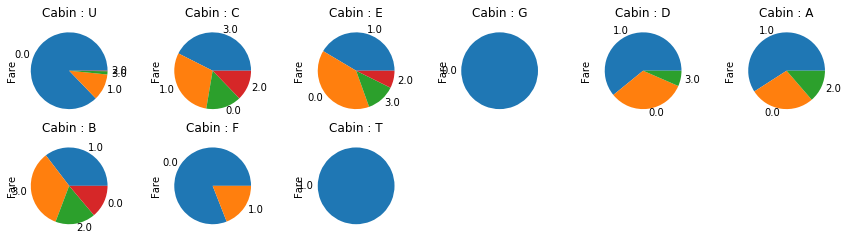

In [187]:
fig = plt.figure(figsize=(15,6))


i=1
for x in all_df['Cabin'].unique():
    fig.add_subplot(3, 6, i)
    plt.title('Cabin : {}'.format(x))
    all_df.Fare[all_df['Cabin'] == x].value_counts().plot(kind='pie')
    i += 1


In [192]:
all_df['Cabin'].value_counts()
all_df[all_df['Cabin']=='T']

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,age_point,Familysize,maybe_dad,fs_point,Pclass_point,Em_point
339,339,340,0.0,1,"Blackwell, Mr. Stephen Weart",1,7.0,0,0,113784,1.0,T,0,1,3,1,1,3,2.0,0.0


In [197]:
### 아까 Cabin의 값을 U로 넣어준 사람들에게 존재하는 Cabin값으로 넣어주기 위해 
### 각 Cabin별로 어떤 Fare범위가 가장 많은지 확인하고 해당 값으로 U값을 대체한다.


for dataset in all_df_list:
    dataset.loc[(dataset['Cabin']=='U')&(dataset['Fare']==0), 'Cabin'] = 'G',
    dataset.loc[(dataset['Cabin']=='U')&(dataset['Fare']==1), 'Cabin'] = 'T',
    dataset.loc[(dataset['Cabin']=='U')&(dataset['Fare']==2), 'Cabin'] = 'C',
    dataset.loc[(dataset['Cabin']=='U')&(dataset['Fare']==3), 'Cabin'] = 'B'

all_df['Cabin'].unique()

array(['G', 'C', 'E', 'T', 'D', 'A', 'B', 'F'], dtype=object)

In [198]:
# 사망률이 높은 범주 확인

c=pd.DataFrame()
for x in all_df['Cabin'].unique():
    a=pd.DataFrame(all_df.Survived[all_df['Cabin']==x].value_counts()/sum(all_df.Survived[all_df['Cabin']==x].value_counts()),
                      columns=['Survived', 'Cabin_replace'])
    a=a[a.index==0]
    a['Cabin_replace']=x
    c=c.append(a)
c=c.drop_duplicates(['Cabin_replace'],keep='last').sort_values(by=['Survived'], ascending=False).reset_index(drop=True)
c 


,Survived,Cabin_replace
0,0.710963,G
1,0.679487,T
2,0.533333,A
3,0.409836,C
4,0.384615,F
5,0.250000,E
6,0.245614,B
7,0.242424,D


In [200]:
cabin_replace={
    'G':0,
    'T':1,
    'A':2,
    'C':3,
    'F':4,
    'E':5,
    'B':6,
    'D':7
}

In [209]:
all_df['Cabin_point']=all_df['Cabin'].apply(lambda x: cabin_replace.get(x))


0       1
1       6
2       5
3       6
4       1
       ..
1304    1
1305    6
1306    1
1307    1
1308    4
Name: surname, Length: 1309, dtype: int64

In [213]:
all_df['age_point']

0        5
1        8
2        4
3        1
4        1
        ..
1304     1
1305     8
1306     8
1307     1
1308    10
Name: age_point, Length: 1309, dtype: int64

# Modeling

In [216]:
from sklearn.preprocessing import StandardScaler
for dataset in all_df_list:
    dataset['surname'] = StandardScaler().fit_transform(dataset['surname'].values.reshape(-1,1))
    dataset['Sex'] = StandardScaler().fit_transform(dataset['Sex'].values.reshape(-1,1))
    dataset['maybe_dad'] = StandardScaler().fit_transform(dataset['maybe_dad'].values.reshape(-1,1))
    dataset['fs_point'] = StandardScaler().fit_transform(dataset['fs_point'].values.reshape(-1,1))
    dataset['Em_point'] = StandardScaler().fit_transform(dataset['Em_point'].values.reshape(-1,1))
    dataset['Cabin_point'] = StandardScaler().fit_transform(dataset['Cabin_point'].values.reshape(-1,1))
    dataset['Pclass_point'] = StandardScaler().fit_transform(dataset['Pclass_point'].values.reshape(-1,1))
    dataset['age_point'] = StandardScaler().fit_transform(dataset['age_point'].values.reshape(-1,1))
    dataset['Fare_point'] = StandardScaler().fit_transform(dataset['Fare_point'].values.reshape(-1,1))
    

In [238]:
# train data의 y값
all=all_df.copy()

train_y=pd.DataFrame()
for i in list(range(0,1309)):
    if all['PassengerId'][i] in train_id:
        a=all[all['PassengerId']==i+1]
        train_y=train_y.append(a)
        

train_y=train_y['Survived'].values

# all_x값만 제공
all_x=all.drop(['Survived'],axis=1).copy()


# all_x에서 train, test 제공
train_x=pd.DataFrame()
test_x=pd.DataFrame()

for i in list(range(0,1309)):
    if all_x['PassengerId'][i] in train_id:
        a=all_x[all_x['PassengerId'] == i+1]
        train_x=train_x.append(a)
        
    elif all_x['PassengerId'][i] in test_id:
        b=all_x[all_x['PassengerId'] == i+1]
        test_x=test_x.append(b)



In [239]:
train_x.columns.unique()
test_x.columns.unique()

Index(['index', 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'surname', 'age_point',
       'Familysize', 'maybe_dad', 'fs_point', 'Pclass_point', 'Em_point',
       'Cabin_point', 'Fare_point'],
      dtype='object')

Index(['index', 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'surname', 'age_point',
       'Familysize', 'maybe_dad', 'fs_point', 'Pclass_point', 'Em_point',
       'Cabin_point', 'Fare_point'],
      dtype='object')

In [240]:
train_x.drop(['Name','index','PassengerId','Pclass','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Familysize'], axis=1, inplace=True)
test_x.drop(['Name','index','PassengerId','Pclass','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Familysize'], axis=1, inplace=True)

In [241]:
train_x
test_x

,Sex,surname,age_point,maybe_dad,fs_point,Pclass_point,Em_point,Cabin_point,Fare_point
0,0.743497,-0.809798,0.264635,0.179818,0.874657,-0.841916,-0.622279,-0.559239,-0.588426
1,-1.344995,1.535392,1.321827,0.179818,0.874657,1.546098,1.834926,0.874268,1.560109
2,-1.344995,1.066354,-0.087763,0.179818,-0.545847,-0.841916,-0.622279,-0.559239,-0.588426
3,-1.344995,1.535392,-1.144955,0.179818,0.874657,1.546098,-0.622279,0.874268,1.560109
4,0.743497,-0.809798,-1.144955,0.179818,-0.545847,-0.841916,-0.622279,-0.559239,-0.588426
...,...,...,...,...,...,...,...,...,...
886,0.743497,-1.278836,-0.087763,0.179818,-0.545847,0.352091,-0.622279,-0.559239,-0.588426
887,-1.344995,1.066354,-0.792558,0.179818,-0.545847,1.546098,-0.622279,2.307774,-0.588426
888,-1.344995,1.066354,0.264635,0.179818,2.295162,-0.841916,-0.622279,-0.559239,-0.588426
889,0.743497,-0.809798,-0.087763,0.179818,-0.545847,1.546098,1.834926,0.874268,-0.588426


,Sex,surname,age_point,maybe_dad,fs_point,Pclass_point,Em_point,Cabin_point,Fare_point
891,0.743497,-0.809798,-1.144955,0.179818,-0.545847,-0.841916,0.606323,-0.559239,-0.588426
892,-1.344995,1.535392,0.617032,0.179818,0.874657,-0.841916,-0.622279,-0.559239,-0.588426
893,0.743497,-0.809798,-1.497353,0.179818,-0.545847,0.352091,0.606323,-0.559239,-0.588426
894,0.743497,-0.809798,-0.087763,0.179818,-0.545847,-0.841916,-0.622279,-0.559239,-0.588426
895,-1.344995,1.535392,0.264635,0.179818,1.584910,-0.841916,-0.622279,-0.559239,-0.588426
...,...,...,...,...,...,...,...,...,...
1304,0.743497,-0.809798,-1.144955,0.179818,-0.545847,-0.841916,-0.622279,-0.559239,-0.588426
1305,-1.344995,1.535392,1.321827,0.179818,-0.545847,1.546098,1.834926,0.874268,1.560109
1306,0.743497,-0.809798,1.321827,0.179818,-0.545847,-0.841916,-0.622279,-0.559239,-0.588426
1307,0.743497,-0.809798,-1.144955,0.179818,-0.545847,-0.841916,-0.622279,-0.559239,-0.588426


In [72]:
train_x_data=train_x.values
test_x_data=test_x.values


In [257]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
# clf = DecisionTreeClassifier()
clf.fit(train_x, train_y)
 

prediction = clf.predict(test_x).astype(int)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": prediction
    })
 
submission.to_csv('submission_200618_reference.csv', index=False)
submission = pd.read_csv('submission_200618_reference.csv')
submission.head()




SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
